# Réalisez une application mobile de recommandation de contenu

## Sommaire

* [I. Préambule](#I)
* [II. Analyse exploiratoire de données](#II)
* [III. Modélisation des données](#III)
    * [1. Content-Based Recommender System](#III1)
    * [2. Collaborative filtering](#III2)
* [IV. Déploiement de l'Azure Functions](#IV)
        
## I. Préambule<a class="anchor" id="I"></a>

My Content est une start-up qui veut encourager la lecture en recommandant des contenus pertinents pour ses utilisateurs.

Je suis le CTO et cofondateur de la start-up avec Samia qui est CEO. Je suis en pleine construction d’un premier MVP qui prendra la forme d’une application mobile. 

Dans un premier temps, notre start-up souhaite tester une solution de recommandation d’articles et de livres à des particuliers.

Les données représentent les interactions des utilisateurs avec les articles disponibles. Elles contiennent des informations sur les articles (par exemple le nombre de mots dans l’article), ainsi que les informations sur les sessions des utilisateurs (par exemple heures de début et de fin) et les interactions des utilisateurs avec les articles (Sur quel article l’utilisateur a-t-il cliqué lors de sa session ?).

In [1]:
# Import libraries
import os

# Math libraries to process the data 
import numpy as np 
import pandas as pd
import progressbar
import pickle

# Libraries for preprocessing
from surprise import Dataset
from surprise import Reader
from collections import defaultdict

# Classification libraries
from sklearn.metrics.pairwise import cosine_similarity
from time import time
from surprise.model_selection import train_test_split
import random
from surprise import KNNWithMeans

# Graph libraries to produce graphs 
import matplotlib.pyplot as plt 
import seaborn as sns 
import plotly.express as px

pd.options.mode.chained_assignment = None

## II. Analyse exploiratoire de données<a class="anchor" id="II"></a>

Nous allons charger les données en mémoire.

In [2]:
def load_data(src_path, click_path):
    '''
    Fonction utilisée pour charger les données du site "News Portal" de Globo.com

    Parameters:
        src_path : chemin vers le dossier contenant les metadonnées et la matrice embedding des articles
        click_path : chemin vers le dossier contenant les fichiers d'interactions des utilisateurs (1 fichier par heure)
    
    Returns:
        articles (dataframe) : les métadonnées des articles (id, catégorie, date de publication, nombre de mots)
        embeddings (array) : matrice de 250 vecteurs des mots contenus dans les articles
        clicks (dataframe)  : les interactions ou clicks des utilisateurs avec les articles
    '''
    # Load articles' metadata
    articles = pd.read_csv(src_path / 'articles_metadata.csv')
    
    # Drop useless feature
    articles.drop(columns=['publisher_id'], inplace=True)
    
    # Convert all data types to integer
    articles = articles.astype(np.int64)

    # Load articles' embedding
    embeddings = pd.read_pickle(src_path / 'articles_embeddings.pickle')
    
    # Change data type from float64 to float32
    embeddings = embeddings.astype(np.float32)

    # Load user interactions with articles
    clicks = pd.DataFrame().append(
        [pd.read_csv(click_path / file) for file in sorted(os.listdir(click_path))],ignore_index=True
    )
    
    # Rename columns
    clicks.rename(columns={'click_article_id': 'article_id'}, inplace=True)
    
    # Drop useless feature
    clicks.drop(
        columns=[
            'click_environment', 
            'click_deviceGroup',
            'click_os', 
            'click_country',
            'click_region',
            'click_referrer_type'
        ], inplace=True
    )
    
    # Convert all data types to integer
    clicks = clicks.astype(np.int64)

    return articles, embeddings, clicks

from pathlib import Path
# Set general configurations
src_path = Path('data')
click_path = Path('data/clicks')

# Call the function to load data
articles, embeddings, clicks = load_data(src_path, click_path)

# Display shape
print('Articles Dataframe shape: ', articles.shape)
print('Embedding Matrix shape: ', embeddings.shape)
print('Clicks Dataframe shape: ', clicks.shape)

Articles Dataframe shape:  (364047, 4)
Embedding Matrix shape:  (364047, 250)
Clicks Dataframe shape:  (2988181, 6)


Nous allons maintenant observer quelques valeurs.

In [3]:
articles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 364047 entries, 0 to 364046
Data columns (total 4 columns):
 #   Column         Non-Null Count   Dtype
---  ------         --------------   -----
 0   article_id     364047 non-null  int64
 1   category_id    364047 non-null  int64
 2   created_at_ts  364047 non-null  int64
 3   words_count    364047 non-null  int64
dtypes: int64(4)
memory usage: 11.1 MB


Le fichier de données fourni contient 4 variables pour 364.047 individus.

<AxesSubplot:>

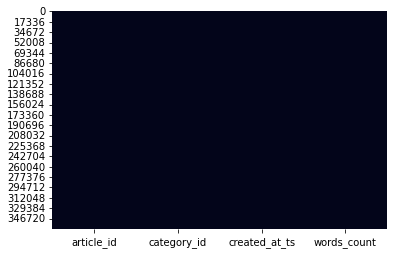

In [4]:
sns.heatmap(articles.isna(), cbar=False)

Toutes les colonnes de notre fichier sont parfaitement renseignées.

In [5]:
articles['words_count'].describe()

count    364047.000000
mean        190.897727
std          59.502766
min           0.000000
25%         159.000000
50%         186.000000
75%         218.000000
max        6690.000000
Name: words_count, dtype: float64

Le nombre de mots par article peut atteindre au maximum 6.690 et au minimum 0 avec une moyenne de 190 mots par article. 

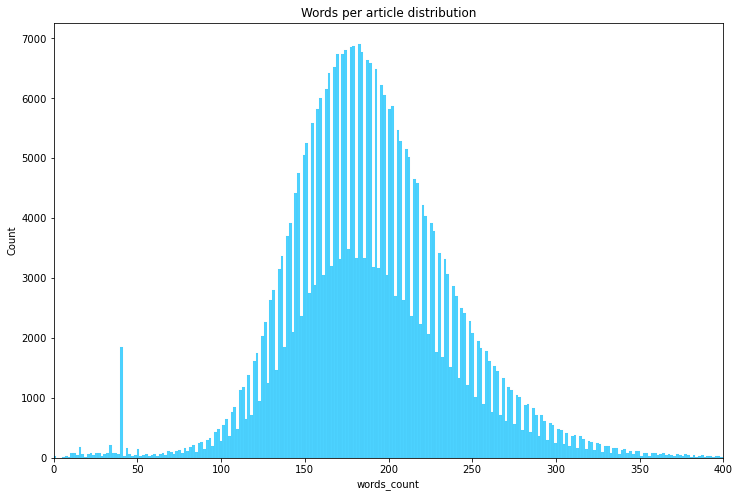

In [6]:
fig, ax = plt.subplots(figsize=(12, 8))

sns.histplot(articles['words_count'],
            color="deepskyblue",
            edgecolor="black",
            alpha=0.7,
            ax=ax)

plt.xlim([0,400])
plt.title('Words per article distribution');
plt.show()

On peut remarquer ici que la distribution du nombre de mots par article suit une distribution normale.

In [7]:
articles['created_at_ts'] = pd.to_datetime(
    (
        pd.to_datetime(
            articles['created_at_ts'],
            unit='ms'
        )
    ).dt.strftime('%Y/%m/%d'))

print('Min/Max creation date:', articles['created_at_ts'].min(), '/ ', articles['created_at_ts'].max())

print('Articles metadata:', articles.shape)
articles.head()

Min/Max creation date: 2006-09-27 00:00:00 /  2018-03-13 00:00:00
Articles metadata: (364047, 4)


,article_id,category_id,created_at_ts,words_count
0,0,0,2017-12-13,168
1,1,1,2014-07-14,189
2,2,1,2014-08-22,250
3,3,1,2014-08-19,230
4,4,1,2014-08-03,162


Les articles que nous avons à disposition vont du 27 septembre 2006 au 13 mars 2018.

In [8]:
clicks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2988181 entries, 0 to 2988180
Data columns (total 6 columns):
 #   Column           Dtype
---  ------           -----
 0   user_id          int64
 1   session_id       int64
 2   session_start    int64
 3   session_size     int64
 4   article_id       int64
 5   click_timestamp  int64
dtypes: int64(6)
memory usage: 136.8 MB


Le fichier clicks contient 6 variables pour 2.988.181 individus.

In [9]:
# Check unique values per column
print('=== Valeurs uniques des features de la table des interactions ===')
print('=================================================================')
for col in clicks.columns:
    print(col, ' :', clicks[col].nunique())

=== Valeurs uniques des features de la table des interactions ===
user_id  : 322897
session_id  : 1048594
session_start  : 646874
session_size  : 72
article_id  : 46033
click_timestamp  : 2983198


On peut constater que nous avons 322.897 utilisateurs uniques.

In [10]:
df_embeddings = pd.DataFrame(embeddings)
df_embeddings = df_embeddings.add_prefix('dim_')

# Display shape and 5 first rows
print('Embeddings des articles: ', df_embeddings.shape)
df_embeddings.head()

Embeddings des articles:  (364047, 250)


,dim_0,dim_1,dim_2,dim_3,dim_4,dim_5,dim_6,dim_7,dim_8,dim_9,...,dim_240,dim_241,dim_242,dim_243,dim_244,dim_245,dim_246,dim_247,dim_248,dim_249
0,-0.161183,-0.957233,-0.137944,0.050855,0.830055,0.901365,-0.335148,-0.559561,-0.500603,0.165183,...,0.321248,0.313999,0.636412,0.169179,0.540524,-0.813182,0.286870,-0.231686,0.597416,0.409623
1,-0.523216,-0.974058,0.738608,0.155234,0.626294,0.485297,-0.715657,-0.897996,-0.359747,0.398246,...,-0.487843,0.823124,0.412688,-0.338654,0.320787,0.588643,-0.594137,0.182828,0.397090,-0.834364
2,-0.619619,-0.972960,-0.207360,-0.128861,0.044748,-0.387535,-0.730477,-0.066126,-0.754899,-0.242004,...,0.454756,0.473184,0.377866,-0.863887,-0.383365,0.137721,-0.810877,-0.447580,0.805932,-0.285284
3,-0.740843,-0.975749,0.391698,0.641738,-0.268645,0.191745,-0.825593,-0.710591,-0.040099,-0.110514,...,0.271535,0.036040,0.480029,-0.763173,0.022627,0.565165,-0.910286,-0.537838,0.243541,-0.885329
4,-0.279052,-0.972315,0.685374,0.113056,0.238315,0.271913,-0.568816,0.341194,-0.600554,-0.125644,...,0.238286,0.809268,0.427521,-0.615932,-0.503697,0.614450,-0.917760,-0.424061,0.185484,-0.580292


364.047 articles sont disponibles dans la base.

## III. Modélisation des données<a class="anchor" id="III"></a>

Nous allons tester deux modèles différents pour mettre en oeuvre notre MVP : **Content-Based Recommender System** et **Collaborative filtering**.

### 1. Content-Based Recommender System<a class="anchor" id="III1"></a>

**Les systèmes de recommandation** sont des systèmes de filtrage d'informations actifs qui personnalisent les informations transmises à un utilisateur en fonction de ses intérêts, de la pertinence des informations, etc. Les systèmes de recommandation sont très utilisés pour recommander des films, des articles, des restaurants, des lieux à visiter, des articles à acheter, etc.

Un **Content-Based Recommender System** fonctionne avec les données fournies par l'utilisateur, soit explicitement (notation), soit implicitement (clic sur un lien). Sur la base de ces données, un profil d'utilisateur est généré, qui est ensuite utilisé pour faire des suggestions à l'utilisateur. Au fur et à mesure que l'utilisateur fournit plus d'entrées ou prend des mesures sur ces recommandations, le moteur devient de plus en plus précis.

**Un système de recommandation** doit choisir entre deux méthodes de diffusion d'informations lorsqu'il fournit des recommandations à l'utilisateur :
* Exploitation : le système choisit des documents similaires à ceux pour lesquels l'utilisateur a déjà exprimé une préférence ;
* Exploration : le système sélectionne les documents dont le profil de l'utilisateur ne fournit pas de preuves pour prédire la réaction de l'utilisateur.

In [11]:
def get_content_based_recommendation(user_id, clicks, embeddings, n_reco=5):
    '''Return n_reco recommended articles ID to user'''
    start = time()

    # Print targetted user_id
    print('The user id is:', user_id)

    # Get the list of articles viewed by the user
    var = clicks.loc[clicks.user_id == user_id]['article_id'].to_list()
    
    # Select the last element of the list (most recent one)
    value = var[-1]
    print('The last article seen by the user is:', value)
    
    # Delete already viewed articles except the selected one
    emb = embeddings
    for i in range (0, len(var)):
        if i != value:
            emb = np.delete(emb, [i], 0)
    
    # Delete selected article from the new matrix
    temp = np.delete(emb, [value], 0)

    # Get n_reco articles which are the most similar to the selected one
    distances = cosine_similarity([emb[value]], temp)[0]
    
    # Find the indexes, except the selected article
    ranked_ids = np.argsort(distances)[::-1][0:n_reco]
    print(f'Model executed in {round(time() - start, 2)}s')
    print('The recommended articles are:')
    
    return ranked_ids.tolist()

# Call the function
user_id = 0
n_reco = 5
recommendation = get_content_based_recommendation(user_id, clicks, embeddings, n_reco)
print(recommendation)

The user id is: 0
The last article seen by the user is: 87205
Model executed in 1.31s
The recommended articles are:
[102720, 100020, 102412, 102611, 86703]


### 2. Collaborative filtering<a class="anchor" id="III2"></a>

Le Collaborative filtering est une technique qui peut filtrer les éléments qu'un utilisateur pourrait aimer sur la base des réactions d'utilisateurs similaires.

Cela fonctionne en recherchant un grand groupe de personnes et en trouvant un plus petit ensemble d'utilisateurs ayant des goûts similaires à un utilisateur particulier. Il examine les éléments qu'ils aiment et les combine pour créer une liste classée de suggestions.

Il existe de nombreuses façons de déterminer quels utilisateurs sont similaires et de combiner leurs choix pour créer une liste de recommandations. Ici, nous nous baserons sur les catégories lues par les utilisateurs.

Nous allons utiliser l'algorithme **KNNWithMeans** de la librairie **Surprise**. C'est un algorithme de collaborative filtering basique, prenant en compte les notes moyennes de chaque utilisateur.

In [12]:
def predict_best_category_for_user(user_id, model, n_reco=5):
    '''Return n_reco recommended articles ID to user'''
    start = time()

    # Print targetted user_id
    print('The user id is:', user_id)
    
    predictions = {}
    
    # Category 1 to 460
    for i in range(1, 460):
        _, category_id, _, est, err = model.predict(user_id, i)
        
        # Keep prediction only if we could keep it.
        if (err != True):
            predictions[category_id] = est
    
    best_categories_to_recommend = dict(sorted(predictions.items(), key=lambda x: x[1], reverse=True)[:n_reco])
    
    recommended_articles = []
    for key, _ in best_categories_to_recommend.items():
        recommended_articles.append(int(articles[articles['category_id'] == key]['article_id'].sample(1).values))
        
    print(f'Model executed in {round(time() - start, 2)}s')
    print(f'The recommended categories are: {list(best_categories_to_recommend.keys())}')
    print(f'1 random article from each categories: {recommended_articles}')
    
    return recommended_articles, best_categories_to_recommend


# To use item-based cosine similarity
sim_options = {
    "name": "cosine",
    # Compute similarities between items
    "user_based": False,  
}

#Create a map to convert article_id to category
dict_article_categories = articles.set_index('article_id')['category_id'].to_dict()

#Get Categorie associate for each article
clicks['category_id'] = clicks['article_id'].map(dict_article_categories).astype(int)
clicks['total_click'] = clicks.groupby(['user_id'])['article_id'].transform('count')
clicks['total_click_by_category_id'] = clicks.groupby(['user_id','category_id'])['article_id'].transform('count')
clicks['rating'] = clicks['total_click_by_category_id'] / clicks['total_click']


# A reader is still needed but only the rating_scale param is requiered.
reader = Reader(rating_scale=(0, 1))

data = Dataset.load_from_df(clicks[['user_id', 'category_id', 'rating']], reader)
train_set, test_set = train_test_split(data, test_size=.25)
model = KNNWithMeans(sim_options=sim_options).fit(train_set)

user_id = 0
n_reco = 5
results, recommended_categories = predict_best_category_for_user(user_id, model, n_reco)

Computing the cosine similarity matrix...
Done computing similarity matrix.
The user id is: 0
Model executed in 1.25s
The recommended categories are: [362, 310, 202, 370, 287]
1 random article from each categories: [226710, 192032, 91212, 227593, 164355]


## IV. Déploiement de l'Azure Functions<a class="anchor" id="IV"></a>

Pour le déploiement de notre module de prédiction, nous avons utilisé une architecture serverless avec Azure Functions.  Azure Functions est un service permettant de mettre en place rapidement ce type d’architecture dans le cloud. Les données utilisées pour effecture la prédiction sont, quant à elles, stockées dans un conteneur Blob. Le stockage Blob Azure est la solution de stockage d’objet de Microsoft pour le cloud. La mémoire maximale par instance de fonction étant limitée à 1.5Go, nous avons réduit nos données à 10.000 utilisateurs.

In [13]:
# Create new file with user_id filtering (10000)
small_clicks = clicks[clicks.user_id.isin(range(0,10000))]

# Display shape and 5 first rows
print("small_clicks shape:", small_clicks.shape)

# Nb of unique article_id
print("Nb unique article_id:", small_clicks.article_id.nunique())

# Save the small clicks data to CSV
small_clicks.to_csv('data/small_clicks.csv', index=False)

small_clicks shape: (225648, 10)
Nb unique article_id: 12423


Nous ne garderons que les articles consultés par ces 10.000 utilisateurs, soit 12.423.

In [14]:
# Build the article id list
list_article_id = sorted(list(small_clicks.article_id.unique()))

# Create a filtered dataframe
test_embeddings = df_embeddings[df_embeddings.index.isin(list_article_id)]

# Convert to numpy
small_embeddings = test_embeddings.to_numpy()
print("small_embeddings shape:", small_embeddings.shape)

# Save as Pickle
pickle.dump(small_embeddings, open('data/small_embeddings.pickle', 'wb'))

# Reload if necessary
small_embeddings = pd.read_pickle('data/small_embeddings.pickle')

small_embeddings shape: (12423, 250)


Nous adaptons notre script pour qu'il puisse, d'une part, faire pointer correctement un article_id à l'embeddings correspondant (en effet, un Numpy array n'a pas d'index explicite) et, d'autre part, afficher la liste des recommandations dans un format qui peut être lu par notre application mobile.

In [15]:
def get_content_based_recommendation(user_id, clicks, embeddings, n_reco=5):
    '''Return 5 recommended articles id to user'''

    # Get the list of articles viewed by the user
    var = clicks.loc[clicks.user_id == user_id]['article_id'].to_list()

    # Get the list of unique article_id in clicks
    list_article_id = sorted(list(clicks.article_id.unique()))

    # Retrieve the corresponding index of the articles viewed by user_id in var
    idx_var = []
    for i in range(0, len(var)):
        for idx, item in enumerate(list(list_article_id)):
            if item == var[i]:
                idx_var.append(idx)

    # Select the last element of the list
    value = idx_var[-1]

    # Compute the cosine similarity
    emb = embeddings
    distances = cosine_similarity([emb[value]], emb)[0]

    # Save the result in Pandas DataFrame
    df_recommendation = pd.DataFrame(list(zip(list_article_id, distances)), columns=(["recommended_article_id", "similarity"]))
    
    # Sort the dataframe by similarity
    df_recommendation.sort_values(by='similarity', ascending=False, inplace=True)

    # Exclude already viewed articles
    top_recommendation = df_recommendation[~df_recommendation.recommended_article_id.isin(var)]

    # Give the list of recommended articles
    result = list(top_recommendation["recommended_article_id"].iloc[:(n_reco)].values)

    return result

# Choose a user_id
user_id = 5659

# Save the function in a variable
recommendations = get_content_based_recommendation(user_id, small_clicks, small_embeddings, n_reco=5)

# Display the result
recommendations

[162605, 157725, 158040, 161868, 158657]